In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import pickle
from tqdm.auto import trange, tqdm

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 모델 트레이닝

In [ ]:
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_train_X.pkl', 'rb') as f:
    dnn_train_X = pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_train_y.pkl', 'rb') as f:
    dnn_train_y = pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_val_X.pkl', 'rb') as f:
    dnn_val_X = pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_val_y.pkl', 'rb') as f:
    dnn_val_y = pickle.load(f)

In [ ]:
dnn_train_shuffle = pd.concat([dnn_train_X,dnn_train_y], axis=1).sample(frac=1, random_state=42)

dnn_train_y = dnn_train_shuffle['spead']
dnn_train_X = dnn_train_shuffle.drop('spead', axis=1)

In [ ]:
def create_model(num_hidden_layers, num_dense_node, leaky_relu = 0.02):
    """
    주어진 히든 레이어 수에 따라 DNN 모델을 생성하는 함수

    :param input_dim: 입력 레이어의 노드 수
    :param num_hidden_layers: 히든 레이어의 수
    :num_dense_node: 레이어 하나에 노드 수
    :leaky_relu: LeakyReLU의 alpha 값
    :return: 생성된 모델
    """
    model = Sequential()
    model.add(Dense(num_dense_node, input_shape=(31,)))
    model.add(LeakyReLU(alpha=leaky_relu))

    for _ in range(num_hidden_layers):
        model.add(Dense(num_dense_node))
        model.add(LeakyReLU(alpha=leaky_relu))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error')

    return model

In [ ]:
# 히든 레이어 수와, 각 레이어의 노드 수
model = create_model(num_hidden_layers = 10, num_dense_node = 64)
model.summary()  # 모델 구조 출력

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 64)                2048      
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_52 (Dense)            (None, 64)               

In [ ]:
early_stopping = EarlyStopping(patience=70)
model_checkpoint = ModelCheckpoint('best_model2.h5', save_best_only=True, monitor='val_loss')

hist = model.fit(dnn_train_X, dnn_train_y, epochs=300, batch_size=32,
                 validation_data=(dnn_val_X, dnn_val_y),
                 callbacks=[early_stopping, model_checkpoint])

Epoch 1/300
756/756 [==============================] - 8s 6ms/step - loss: 55.6360 - val_loss: 44.4385
Epoch 2/300
 24/756 [..............................] - ETA: 3s - loss: 39.1618

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


756/756 [==============================] - 4s 5ms/step - loss: 43.8972 - val_loss: 40.4523
Epoch 3/300
756/756 [==============================] - 4s 5ms/step - loss: 42.9272 - val_loss: 43.8318
Epoch 4/300
756/756 [==============================] - 5s 7ms/step - loss: 41.8384 - val_loss: 41.3941
Epoch 5/300
756/756 [==============================] - 4s 5ms/step - loss: 41.7253 - val_loss: 37.4097
Epoch 6/300
756/756 [==============================] - 4s 5ms/step - loss: 41.0085 - val_loss: 37.7561
Epoch 7/300
756/756 [==============================] - 4s 5ms/step - loss: 41.3630 - val_loss: 35.9452
Epoch 8/300
756/756 [==============================] - 5s 7ms/step - loss: 40.5658 - val_loss: 35.8531
Epoch 9/300
756/756 [==============================] - 4s 5ms/step - loss: 40.4060 - val_loss: 46.0123
Epoch 10/300
756/756 [==============================] - 4s 5ms/step - loss: 39.8598 - val_loss: 37.8719
Epoch 11/300
756/756 [==============================] - 4s 5ms/step - loss: 40.1323 

In [ ]:
# 모델 사용하기
loaded_model = load_model('best_model2.h5')
loss_and_metrics = loaded_model.evaluate(dnn_val_X, dnn_val_y, batch_size = 32)

print('loss: ', loss_and_metrics)

72/72 [==============================] - 1s 9ms/step - loss: 8.0627
loss:  8.062749862670898


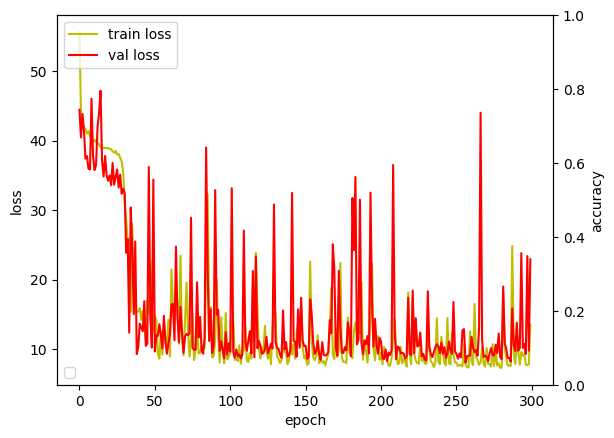

In [ ]:
# 모델 학습과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

#plt.title('layer=13 node=64 loss = '+str(loss_and_metrics))
plt.show()

In [ ]:
# dnn_val_X_reset = dnn_val_X.reset_index(drop=True)
# dnn_val_y_reset = dnn_val_y.reset_index(drop=True)

72/72 [==============================] - 0s 2ms/step


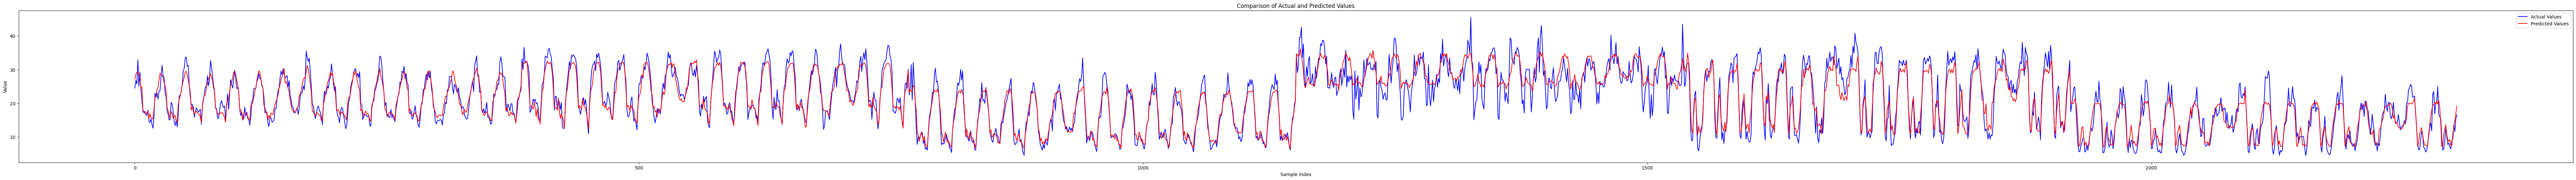

In [ ]:
# 모델을 사용하여 예측 수행
predicted_val_y = loaded_model.predict(dnn_val_X)

# 실제 값과 예측값을 선 그래프로 표시
plt.figure(figsize=(100, 6))
plt.plot(dnn_val_y, label='Actual Values', color='blue')
plt.plot(predicted_val_y, label='Predicted Values', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# 속도 예측

## 예측(임시)

In [ ]:
# 모델 로드
loaded_model = load_model('/content/drive/MyDrive/학교/스마트교차로/dnn_model_예비.h5')

In [ ]:
def prepare_predict_data(signal_values):
    """신호 주기에 따라 딥러닝 모델의 입력 데이터를 준비하는 함수"""
    # LSTM 출력, 날씨/공휴일 데이터 생성 # 수정해야함
    lstm_output = dnn_train_X.iloc[:1,:16].reset_index(drop=True) # lstm_output
    weather_공휴일_data = dnn_train_X.iloc[:1,16:24].reset_index(drop=True) # lstm_input

    # 신호 주기 데이터를 DataFrame으로 변환
    signal = pd.DataFrame([signal_values])

    # 데이터 결합 및 복제
    predict_data = pd.concat([lstm_output, weather_공휴일_data, signal], axis=1)
    predict_data = pd.concat([predict_data] * 6, ignore_index=True)

    # 방향 열 추가
    predict_data['방향'] = list(range(6))

    return predict_data

def evaluate_population(model, population):
    """집단 평가 함수"""
    average_speeds = []
    for individual in population:
        prepared_data = prepare_predict_data(individual)
        predicted_speeds = model.predict(prepared_data, verbose=0)
        average_speeds.append(np.mean(predicted_speeds))
    return np.array(average_speeds)


def select_parents(population, fitness, num_parents):
    """부모 선택 함수"""
    parents = np.empty((num_parents, population.shape[1]), dtype=np.int32)
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))[0][0]
        parents[parent_num, :] = population[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    """교차(교배) 함수"""
    offspring = np.empty(offspring_size, dtype=np.int32)
    crossover_point = np.uint8(offspring_size[1]/2)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutate(offspring_crossover, min_values, max_values):
    """변이 함수"""
    for idx in range(offspring_crossover.shape[0]):
        random_index = np.random.randint(0, offspring_crossover.shape[1], size=1)
        random_value = np.random.randint(-5, 6)  # 정수 변이
        offspring_crossover[idx, random_index] = np.clip(offspring_crossover[idx, random_index] + random_value, min_values[random_index], max_values[random_index])
    return offspring_crossover


def optimize_signal_times(model, min_values, max_values, population_size=50, num_generations=10, num_parents_mating=4):
    """신호 주기 최적화 함수"""
    population = create_initial_population(population_size, min_values, max_values)
    for generation in trange(num_generations):
        fitness = evaluate_population(model, population)
        parents = select_parents(population, fitness, num_parents_mating)
        offspring_crossover = crossover(parents, offspring_size=(population_size - parents.shape[0], population.shape[1]))
        offspring_mutation = mutate(offspring_crossover, min_values, max_values)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = offspring_mutation
        # print(f"전체 진행도{generation}/{num_generations}")
    final_fitness = evaluate_population(model, population)
    best_solution = population[np.argmax(final_fitness)]
    best_solution_speed = np.max(final_fitness)
    return best_solution, best_solution_speed

def create_initial_population(population_size, min_values, max_values):
    """초기 집단 생성 함수"""
    population = []
    for _ in range(population_size):
        individual = np.random.randint(min_values, max_values + 1, size=len(min_values))
        population.append(individual)
    return np.array(population)

In [ ]:
# 최소녹색시간과 최대녹색시간
min_signal_times = np.array([10, 31, 15, 11, 8, 15])
max_signal_times = np.array([83-4, 83-4, 43-4, 43-4, 43-4, 72-4]) # 수정 필요할 듯

best_signal_times, best_speed = optimize_signal_times(loaded_model, min_signal_times, max_signal_times)
print("Best Signal Times:", best_signal_times)
print("Best Speed:", best_speed)

  0%|          | 0/10 [00:00<?, ?it/s]

Best Signal Times: [79 79 28 13 39 15]
Best Speed: 29.310713


## 도로 순서
1. 교대→연산교차로
2. 부산시청→연산교차로
3. 사직운동장→연산교차로
4. 신리→연산교차로
5. 안락→연산교차로
6. 연산터널→연산교차로

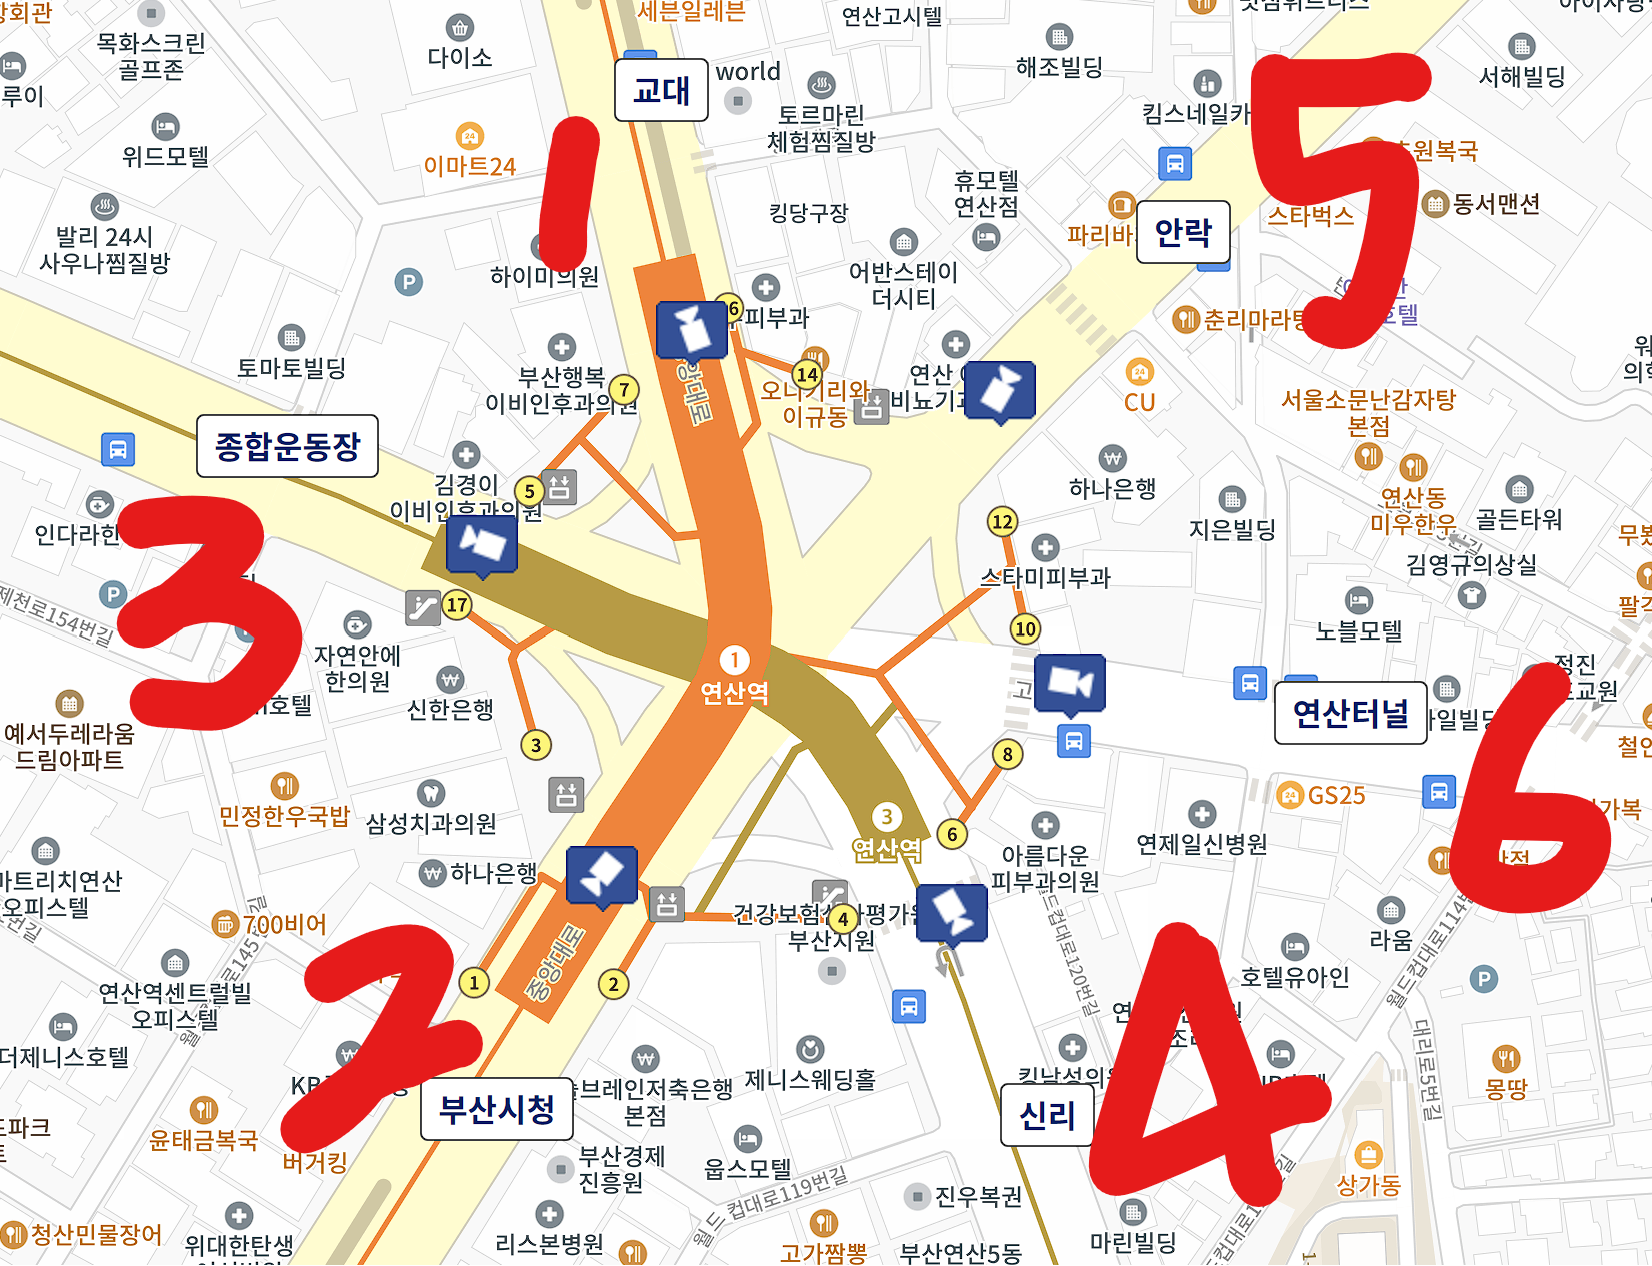

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/학교/스마트교차로/진입로 순번.png", width=500)

In [ ]:
# test sample: 기존 신호
predictions_after = loaded_model.predict(prepare_predict_data([24,	31,	20,	17,	17,	17]))
predictions_after

1/1 [==============================] - 0s 28ms/step


array([[16.612251],
       [18.888016],
       [10.186893],
       [26.472008],
       [14.436716],
       [ 9.282602]], dtype=float32)

In [ ]:
predictions_after = loaded_model.predict(prepare_predict_data(best_signal_times))
predictions_after

1/1 [==============================] - 0s 26ms/step


array([[28.13458 ],
       [28.379602],
       [28.696205],
       [29.779121],
       [30.889832],
       [29.98494 ]], dtype=float32)